In [ ]:
import time
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# === CONFIGURACIÓN ===
MODEL_PATH = "C:/Users/Usuario/Desktop/unAI/CIFAR-10-Python/resnet18_cifar10.pt"  # Ruta al modelo entrenado
BATCH_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else RuntimeError("No GPU available"))
CLASS_NAMES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [33]:
# === CARGAR DATALOADER DE TEST CON UNA TRANSFORMACIÓN ===
def get_test_loader(transform):
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    return torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [34]:
# === EVALUAR Y MOSTRAR MATRIZ DE CONFUSIÓN ===
def evaluate(model, dataloader, title="Confusion Matrix"):
    all_preds, all_labels = [], []

    start = time.time()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end = time.time()
    print(f"Evaluation completed in {end - start:.4f} s")
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    return end-start


In [35]:
# === TRANSFORMACIONES ===
test_transforms = {
    "normal": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    "horizontal_flip": transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    "random_rotation": transforms.Compose([
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    "gaussian_blur": transforms.Compose([
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    "color_jitter": transforms.Compose([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}


=== Evaluando: normal ===
Evaluation completed in 2.7695 s


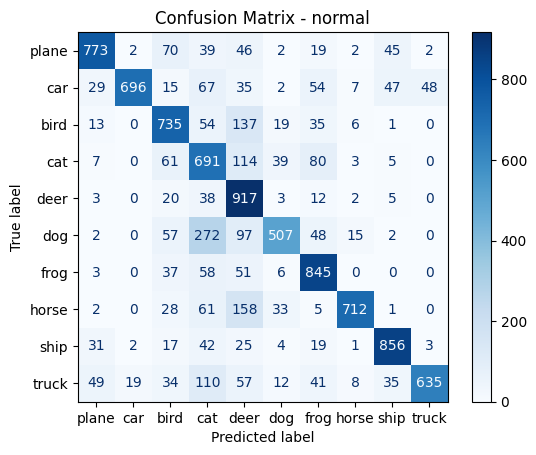


=== Evaluando: horizontal_flip ===
Evaluation completed in 3.1839 s


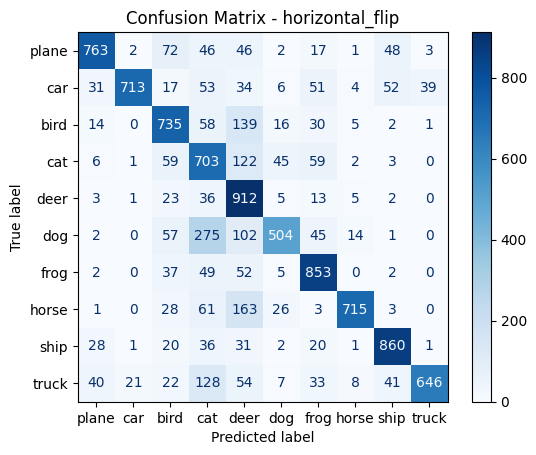


=== Evaluando: random_rotation ===
Evaluation completed in 3.7095 s


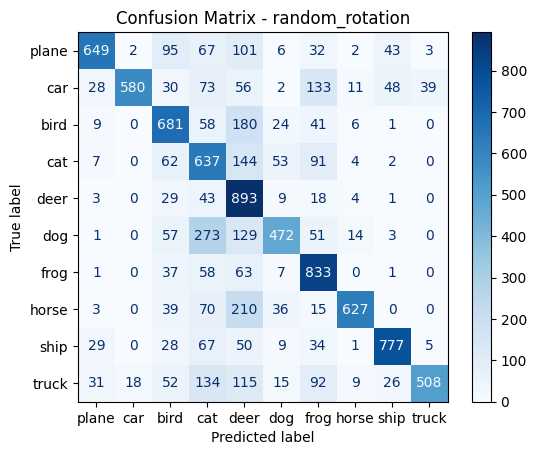


=== Evaluando: gaussian_blur ===
Evaluation completed in 11.7869 s


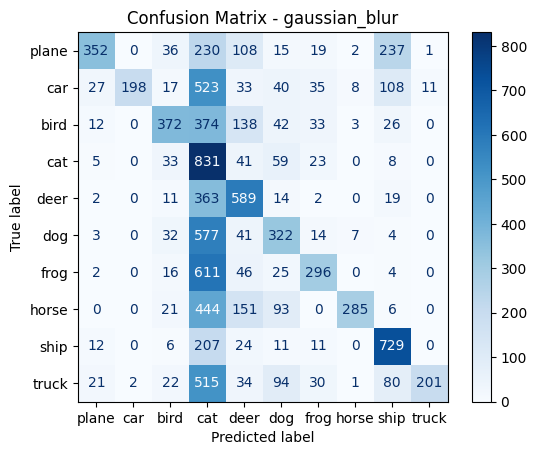


=== Evaluando: color_jitter ===
Evaluation completed in 6.0466 s


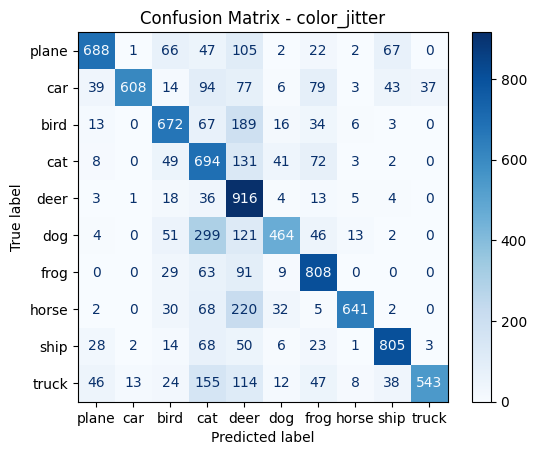


Total GPU time for all transformations: 27.4965 s

Total execution time: 31.7824 s


In [ ]:
# === MAIN ===
if __name__ == "__main__":

    model = models.resnet18()
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    model.to(DEVICE)
    
    start_total = time.time()
    for i in range(11):

        start_loop = time.time()
        gpu_total = 0
        for name, transform in test_transforms.items():
            print(f"\n=== Evaluating: {name} - Iteration {i} ===")
            test_loader = get_test_loader(transform)
            gpu_total += evaluate(model, test_loader, title=f"Confusion Matrix - {name} - Iteration {i}")

        end_loop = time.time()
        print(f"\nTotal GPU time for all transformations: {gpu_total:.4f} s - Iteration {i}")
        print(f"\nTotal execution time: {end_loop - start_loop:.4f} s - Iteration {i}")
    
    end_total = time.time()
    print(f"\nTotal execution time for all loops: {end_total - start_total:.4f} s")